In [2]:
import sys, os
import numpy as np
import pandas as pd
import photoz_utils
import random
import h5py
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import tqdm

In [3]:
photozdata = pd.read_csv('/data/HSC/HSC_v6/HSC_v6.csv')
photozdata.describe()

b = np.argsort(photozdata['object_id'])
sorted_photozdata = photozdata.iloc[b][:]
photozdata = sorted_photozdata

In [3]:
for (columnName, columnData) in photozdata.iteritems():
    print(columnName)

object_id
specz_redshift_err
specz_redshift
specz_mag_i
specz_name
specz_ra
specz_dec
specz_flag_homogeneous
ra
dec
coord
skymap_id
g_cmodel_mag
r_cmodel_mag
i_cmodel_mag
z_cmodel_mag
y_cmodel_mag
g_cmodel_magsigma
r_cmodel_magsigma
i_cmodel_magsigma
z_cmodel_magsigma
y_cmodel_magsigma


/tmp/ipykernel_2770193/3463937130.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in photozdata.iteritems():


In [4]:
hf = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64.hdf5', 'a')

In [17]:
hf_original = h5py.File('/data/HSC/HSC_v6/step2A/127x127/legacy/five_band_image127x127_with_metadata_corrected.hdf5', 'r')
object_id_original = np.asarray(hf_original['object_id'])[..., None]
size = len(object_id_original)

start_index = (127 - 64) // 2
end_index = start_index + 64

In [5]:
for i in tqdm(range(size)):

    five_band_image = []
    
    image = np.asarray(hf_original['image'][i : i + 1])[0]

    image_g = image[0]
    image_r = image[1]
    image_i = image[2]
    image_z = image[3]
    image_y = image[4]

    im_g = image_g[start_index : end_index, start_index : end_index]
    im_r = image_r[start_index : end_index, start_index : end_index]
    im_i = image_i[start_index : end_index, start_index : end_index]
    im_z = image_z[start_index : end_index, start_index : end_index]
    im_y = image_y[start_index : end_index, start_index : end_index]
    
    five_band_image.append(im_g)
    five_band_image.append(im_r)
    five_band_image.append(im_i)
    five_band_image.append(im_z)
    five_band_image.append(im_y)

    # Update five_band_image_reshape to store central 64x64 sections
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
    
    # plt.imshow(five_band_image_reshape[0][0])

    specz = np.asarray(hf_original['specz_redshift'][i : i + 1])[0]
    specz_reshape = np.reshape(specz, [1, 1])

    if i == 0:

        for (columnName, columnData) in photozdata.iteritems():

            if columnName == 'specz_name' or columnName == 'coord':

                hf.create_dataset(columnName, data = np.asarray(hf_original[columnName][i : i + 1]).astype('S')[0], maxshape = (None, ))

            else:

                hf.create_dataset(columnName, data = np.asarray(hf_original[columnName][i : i + 1]), maxshape = (None, ))

        hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 64, 64))

    else:

        for (columnName, columnData) in photozdata.iteritems():

            hf[columnName].resize((hf[columnName].shape[0] + 1), axis = 0)

            if columnName == 'specz_name' or columnName == 'coord':

                hf[columnName][hf[columnName].shape[0] - 1] = np.asarray(hf_original[columnName][i : i + 1]).astype('S')[0]

            else:

                hf[columnName][hf[columnName].shape[0] - 1] = np.asarray(hf_original[columnName][i : i + 1])[0]

        hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
        hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image_reshape

hf.close()

  0%|          | 0/286401 [00:00<?, ?it/s]/tmp/ipykernel_2032709/3208781507.py:42: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in photozdata.iteritems():
  0%|          | 1/286401 [00:00<17:37:36,  4.51it/s]/tmp/ipykernel_2032709/3208781507.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in photozdata.iteritems():
100%|██████████| 286401/286401 [1:40:15<00:00, 47.61it/s]  


In [ ]:
# Check data correctness
hf = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64.hdf5', 'r')
for (columnName, columnData) in tqdm(photozdata.iteritems()):
    # print(np.asarray(hf_original[columnName])[..., None][0:2])
    for i in range(0, 100):
        if np.asarray(hf[columnName])[..., None][i] != np.asarray(hf_original[columnName])[..., None][i]:
            print('error')

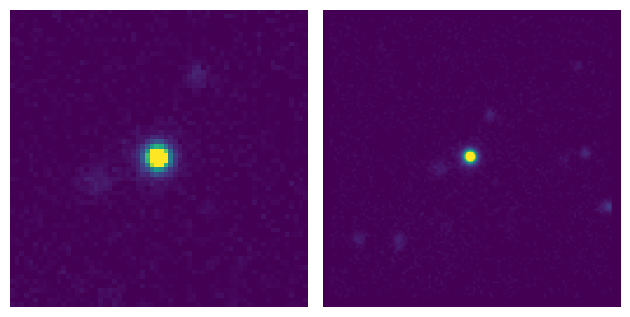

In [7]:
index_to_show = 4
fig, axes = plt.subplots(1, 2)  # 1 row, 2 columns

axes[0].imshow(hf['image'][index_to_show][0], vmin = 0, vmax = 4.16)
axes[0].axis('off')

axes[1].imshow(hf_original['image'][index_to_show][0], vmin = 0, vmax = 4.16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [37]:
# key = np.random.randint(0, 100000)
key = 75992
print(key)

75992


In [38]:
np.random.seed(key)

In [18]:
ntrain = 204573
ntest = 40914
nval = 40914
if ntrain + ntest + nval != size:
    print('error!')

In [39]:
# indices = random.sample(list(np.arange(size)), ntrain + ntest + nval)

In [40]:
# np.save('datasplit_indices.npy', indices)

In [14]:
indices = np.load('datasplit_indices.npy')

In [16]:
inds_train = np.sort(indices[: ntrain])
inds_test = np.sort(indices[ntrain : ntrain + ntest])
inds_val = np.sort(indices[ntrain + ntest :])

In [17]:
hf_split = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64.hdf5', 'r')
dataset_length = len(hf_split['image'])
if dataset_length != size:
    print('error!')

In [20]:
subsizes = [ntrain, ntest, nval]
file_ends = ['_training', '_testing', '_validation']
inds_list = [inds_train, inds_test, inds_val]

for subsize, file_end, inds in zip(subsizes, file_ends, inds_list):
    hf_write = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64' + file_end + '.hdf5', 'w')
    for k in hf_split.keys():
        tmp = hf_split[k]
        subshape = list(np.shape(tmp))
        subshape[0] = subsize
        dataset = hf_write.create_dataset(k, shape = subshape, dtype = tmp.dtype)
        for i, index in tqdm(enumerate(inds)):
            dataset[i] = tmp[index]
        tmp = None

hf_split.close()
hf_write.close()

204573it [00:21, 9334.23it/s]
204573it [00:13, 15253.62it/s]
204573it [00:13, 15404.18it/s]
204573it [00:15, 13201.72it/s]
204573it [00:13, 15161.55it/s]
204573it [00:17, 11443.76it/s]
204573it [04:01, 848.02it/s] 
204573it [00:12, 15750.71it/s]
204573it [00:23, 8757.10it/s] 
204573it [00:20, 9858.95it/s] 
204573it [00:21, 9687.52it/s] 
204573it [00:13, 15694.05it/s]
204573it [00:28, 7199.33it/s] 
204573it [00:22, 9038.21it/s]
204573it [00:13, 15427.58it/s]
204573it [00:22, 9079.47it/s]
204573it [00:13, 14819.83it/s]
204573it [00:13, 15292.89it/s]
204573it [00:13, 15276.38it/s]
204573it [00:20, 10137.76it/s]
204573it [00:27, 7526.66it/s] 
204573it [00:14, 14506.45it/s]
204573it [00:13, 15111.64it/s]
40914it [00:12, 3278.24it/s]
40914it [00:02, 14754.78it/s]
40914it [00:03, 12368.28it/s]
40914it [00:03, 10591.30it/s]
40914it [00:02, 14806.14it/s]
40914it [00:03, 12140.67it/s]
40914it [02:03, 330.60it/s]
40914it [00:02, 15631.77it/s]
40914it [00:02, 14803.67it/s]
40914it [00:02, 15061.59

In [21]:
hf_split = h5py.File('/data/HSC/HSC_v6/temp/127x127/5x127x127.hdf5', 'r')
dataset_length = len(hf_split['image'])
if dataset_length != size:
    print('error!')

In [22]:
subsizes = [ntrain, ntest, nval]
file_ends = ['_training', '_testing', '_validation']
inds_list = [inds_train, inds_test, inds_val]

for subsize, file_end, inds in zip(subsizes, file_ends, inds_list):
    hf_write = h5py.File('/data/HSC/HSC_v6/temp/127x127/5x127x127' + file_end + '.hdf5', 'w')
    for k in hf_split.keys():
        tmp = hf_split[k]
        subshape = list(np.shape(tmp))
        subshape[0] = subsize
        dataset = hf_write.create_dataset(k, shape = subshape, dtype = tmp.dtype)
        for i, index in tqdm(enumerate(inds)):
            dataset[i] = tmp[index]
        tmp = None

hf_split.close()
hf_write.close()

204573it [00:14, 14165.24it/s]
204573it [00:09, 21660.50it/s]
204573it [00:09, 21681.15it/s]
204573it [00:09, 21902.67it/s]
204573it [00:09, 21827.24it/s]
204573it [00:09, 21792.52it/s]
204573it [14:27, 235.86it/s]
204573it [00:08, 23016.85it/s]
204573it [00:09, 21867.88it/s]
204573it [00:09, 21754.87it/s]
204573it [00:09, 21837.45it/s]
204573it [00:09, 22463.43it/s]
204573it [00:09, 21814.92it/s]
204573it [00:15, 12967.24it/s]
204573it [00:09, 21773.37it/s]
204573it [00:14, 14056.57it/s]
204573it [00:09, 21743.03it/s]
204573it [00:09, 22278.71it/s]
204573it [00:09, 21763.46it/s]
204573it [00:09, 21721.66it/s]
204573it [00:09, 20895.86it/s]
204573it [00:09, 20925.16it/s]
204573it [00:09, 21754.46it/s]
40914it [00:02, 14432.01it/s]
40914it [00:02, 20366.57it/s]
40914it [00:01, 21071.81it/s]
40914it [00:01, 21427.73it/s]
40914it [00:01, 22049.64it/s]
40914it [00:01, 21691.69it/s]
40914it [07:09, 95.16it/s] 
40914it [00:01, 22156.98it/s]
40914it [00:01, 22023.09it/s]
40914it [00:01, 21823

In [4]:
hf_train_64 = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64_training.hdf5', 'r')
hf_train_127 = h5py.File('/data/HSC/HSC_v6/temp/127x127/5x127x127_training.hdf5', 'r')

In [8]:
# Check data maching
for (columnName, columnData) in tqdm(photozdata.iteritems()):
    # print(np.asarray(hf_original[columnName])[..., None][0:2])
    for i in range(0, 10):
        if np.asarray(hf_train_64[columnName])[..., None][i] != np.asarray(hf_train_127[columnName])[..., None][i]:
            print('error')

0it [00:00, ?it/s]/opt/anaconda3/envs/jupyterhub/lib/python3.10/site-packages/tqdm/std.py:1182: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for obj in iterable:
22it [00:01, 20.81it/s]


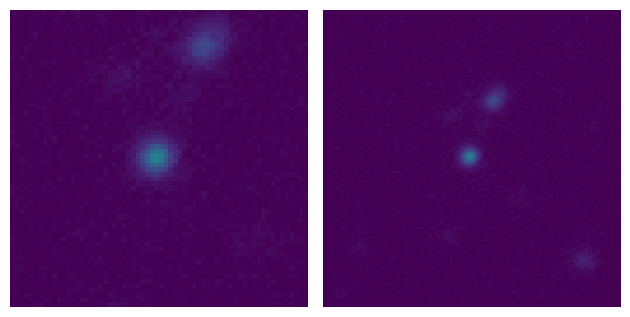

In [7]:
# Check image maching
index_to_show = 400
fig, axes = plt.subplots(1, 2)  # 1 row, 2 columns

axes[0].imshow(hf_train_64['image'][index_to_show][0], vmin = 0, vmax = 4.16)
axes[0].axis('off')

axes[1].imshow(hf_train_127['image'][index_to_show][0], vmin = 0, vmax = 4.16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

22it [00:00, 71.28it/s]


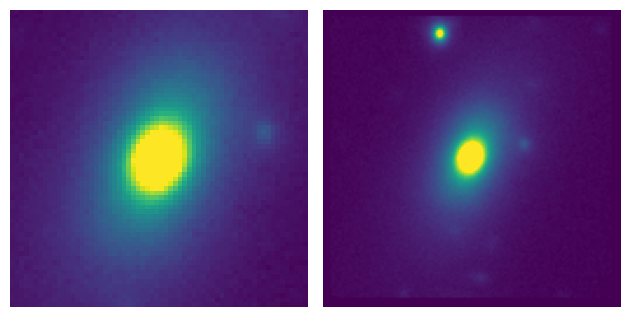

In [9]:
hf_test_64 = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64_testing.hdf5', 'r')
hf_test_127 = h5py.File('/data/HSC/HSC_v6/temp/127x127/5x127x127_testing.hdf5', 'r')

# Check data maching
for (columnName, columnData) in tqdm(photozdata.iteritems()):
    # print(np.asarray(hf_original[columnName])[..., None][0:2])
    for i in range(0, 10):
        if np.asarray(hf_test_64[columnName])[..., None][i] != np.asarray(hf_test_127[columnName])[..., None][i]:
            print('error')
            
# Check image maching
index_to_show = 400
fig, axes = plt.subplots(1, 2)  # 1 row, 2 columns

axes[0].imshow(hf_test_64['image'][index_to_show][0], vmin = 0, vmax = 4.16)
axes[0].axis('off')

axes[1].imshow(hf_test_127['image'][index_to_show][0], vmin = 0, vmax = 4.16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

22it [00:00, 83.12it/s]


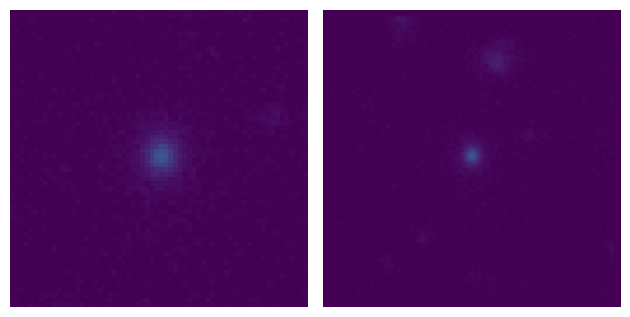

In [10]:
hf_val_64 = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64_validation.hdf5', 'r')
hf_val_127 = h5py.File('/data/HSC/HSC_v6/temp/127x127/5x127x127_validation.hdf5', 'r')

# Check data maching
for (columnName, columnData) in tqdm(photozdata.iteritems()):
    # print(np.asarray(hf_original[columnName])[..., None][0:2])
    for i in range(0, 10):
        if np.asarray(hf_val_64[columnName])[..., None][i] != np.asarray(hf_val_127[columnName])[..., None][i]:
            print('error')
            
# Check image maching
index_to_show = 400
fig, axes = plt.subplots(1, 2)  # 1 row, 2 columns

axes[0].imshow(hf_val_64['image'][index_to_show][0], vmin = 0, vmax = 4.16)
axes[0].axis('off')

axes[1].imshow(hf_val_127['image'][index_to_show][0], vmin = 0, vmax = 4.16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [26]:
# Check metadata
hf_val_64 = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64_validation.hdf5', 'r')
hf_val_127 = h5py.File('/data/HSC/HSC_v6/temp/127x127/5x127x127_validation.hdf5', 'r')

for i in [random.randint(0, nval) for _ in range(10)]:
    print(i)
    object_id_64 = np.asarray(hf_val_64['object_id'][0:])[..., None][i][0]
    object_id_127 = np.asarray(hf_val_127['object_id'][0:])[..., None][i][0]
    for j in range(len(photozdata['object_id'])):
        if photozdata['object_id'][j] == object_id_64:
            if photozdata['object_id'][j] != object_id_64:
                print('error')
            for (columnName, columnData) in photozdata.iteritems():
                if columnName == 'specz_name' or columnName == 'coord': 
                    if np.asarray(photozdata[columnName][j]).astype('S') != np.asarray(hf_val_64[columnName][0:])[..., None][i][0]:
                        print('error')
                    if np.asarray(photozdata[columnName][j]).astype('S') != np.asarray(hf_val_127[columnName][0:])[..., None][i][0]:
                        print('error')
                else:
                    if photozdata[columnName][j] != np.asarray(hf_val_64[columnName][0:])[..., None][i][0]:
                        print('error')
                    if photozdata[columnName][j] != np.asarray(hf_val_127[columnName][0:])[..., None][i][0]:
                        print('error')

24164


/tmp/ipykernel_2834406/2314394084.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in photozdata.iteritems():


28284
15804
2243
31044
17633
24792
36622
20703
8934


In [27]:
# Check metadata
hf_test_64 = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64_testing.hdf5', 'r')
hf_test_127 = h5py.File('/data/HSC/HSC_v6/temp/127x127/5x127x127_testing.hdf5', 'r')

for i in [random.randint(0, ntest) for _ in range(10)]:
    print(i)
    object_id_64 = np.asarray(hf_test_64['object_id'][0:])[..., None][i][0]
    object_id_127 = np.asarray(hf_test_127['object_id'][0:])[..., None][i][0]
    for j in range(len(photozdata['object_id'])):
        if photozdata['object_id'][j] == object_id_64:
            if photozdata['object_id'][j] != object_id_64:
                print('error')
            for (columnName, columnData) in photozdata.iteritems():
                if columnName == 'specz_name' or columnName == 'coord': 
                    if np.asarray(photozdata[columnName][j]).astype('S') != np.asarray(hf_test_64[columnName][0:])[..., None][i][0]:
                        print('error')
                    if np.asarray(photozdata[columnName][j]).astype('S') != np.asarray(hf_test_127[columnName][0:])[..., None][i][0]:
                        print('error')
                else:
                    if photozdata[columnName][j] != np.asarray(hf_test_64[columnName][0:])[..., None][i][0]:
                        print('error')
                    if photozdata[columnName][j] != np.asarray(hf_test_127[columnName][0:])[..., None][i][0]:
                        print('error')

34754


/tmp/ipykernel_2834406/2937527631.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in photozdata.iteritems():


9432
17792
15307
15432
14408
28075
35000
31483
23176


In [28]:
# Check metadata
hf_train_64 = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64_training.hdf5', 'r')
hf_train_127 = h5py.File('/data/HSC/HSC_v6/temp/127x127/5x127x127_training.hdf5', 'r')

for i in [random.randint(0, ntrain) for _ in range(10)]:
    print(i)
    object_id_64 = np.asarray(hf_train_64['object_id'][0:])[..., None][i][0]
    object_id_127 = np.asarray(hf_train_127['object_id'][0:])[..., None][i][0]
    for j in range(len(photozdata['object_id'])):
        if photozdata['object_id'][j] == object_id_64:
            if photozdata['object_id'][j] != object_id_64:
                print('error')
            for (columnName, columnData) in photozdata.iteritems():
                if columnName == 'specz_name' or columnName == 'coord': 
                    if np.asarray(photozdata[columnName][j]).astype('S') != np.asarray(hf_train_64[columnName][0:])[..., None][i][0]:
                        print('error')
                    if np.asarray(photozdata[columnName][j]).astype('S') != np.asarray(hf_train_127[columnName][0:])[..., None][i][0]:
                        print('error')
                else:
                    if photozdata[columnName][j] != np.asarray(hf_train_64[columnName][0:])[..., None][i][0]:
                        print('error')
                    if photozdata[columnName][j] != np.asarray(hf_train_127[columnName][0:])[..., None][i][0]:
                        print('error')

149295


/tmp/ipykernel_2834406/1640307826.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in photozdata.iteritems():


18245
89670
177688
161848
138183
48724
176091
36830
82959


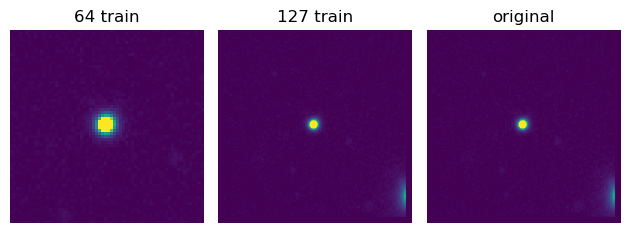

In [32]:
# Check image
hf_original = h5py.File('/data/HSC/HSC_v6/step2A/127x127/legacy/five_band_image127x127_with_metadata_corrected.hdf5', 'r')
object_id_original = np.asarray(hf_original['object_id'])[..., None]

i = random.randint(0, ntrain)

object_id_64 = np.asarray(hf_train_64['object_id'][0:])[..., None][i][0]
object_id_127 = np.asarray(hf_train_127['object_id'][0:])[..., None][i][0]

for j in range(len(object_id_original)):
    if object_id_original[j] == object_id_64:
        if object_id_original[j] != object_id_127:
            print('error')
        original_index = j

fig, axes = plt.subplots(1, 3)  # 1 row, 2 columns

axes[0].imshow(hf_train_64['image'][i][0], vmin = 0, vmax = 4.16)
axes[0].set_title('64 train')
axes[0].axis('off')

axes[1].imshow(hf_train_127['image'][i][0], vmin = 0, vmax = 4.16)
axes[1].set_title('127 train')
axes[1].axis('off')

axes[2].imshow(hf_original['image'][original_index][0], vmin = 0, vmax = 4.16)
axes[2].set_title('original')
axes[2].axis('off')

plt.tight_layout()
plt.show()

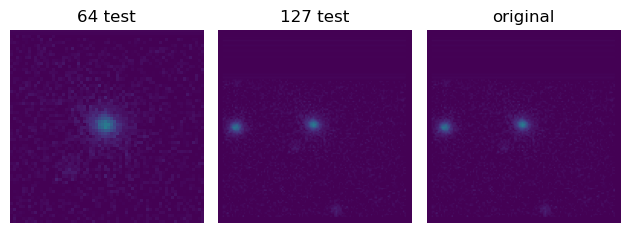

In [35]:
# Check image
hf_original = h5py.File('/data/HSC/HSC_v6/step2A/127x127/legacy/five_band_image127x127_with_metadata_corrected.hdf5', 'r')
object_id_original = np.asarray(hf_original['object_id'])[..., None]

i = random.randint(0, ntest)

object_id_64 = np.asarray(hf_test_64['object_id'][0:])[..., None][i][0]
object_id_127 = np.asarray(hf_test_127['object_id'][0:])[..., None][i][0]

for j in range(len(object_id_original)):
    if object_id_original[j] == object_id_64:
        if object_id_original[j] != object_id_127:
            print('error')
        original_index = j

fig, axes = plt.subplots(1, 3)  # 1 row, 2 columns

axes[0].imshow(hf_test_64['image'][i][0], vmin = 0, vmax = 4.16)
axes[0].set_title('64 test')
axes[0].axis('off')

axes[1].imshow(hf_test_127['image'][i][0], vmin = 0, vmax = 4.16)
axes[1].set_title('127 test')
axes[1].axis('off')

axes[2].imshow(hf_original['image'][original_index][0], vmin = 0, vmax = 4.16)
axes[2].set_title('original')
axes[2].axis('off')

plt.tight_layout()
plt.show()

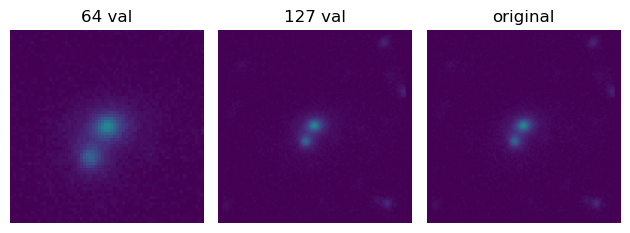

In [34]:
# Check image
hf_original = h5py.File('/data/HSC/HSC_v6/step2A/127x127/legacy/five_band_image127x127_with_metadata_corrected.hdf5', 'r')
object_id_original = np.asarray(hf_original['object_id'])[..., None]

i = random.randint(0, nval)

object_id_64 = np.asarray(hf_val_64['object_id'][0:])[..., None][i][0]
object_id_127 = np.asarray(hf_val_127['object_id'][0:])[..., None][i][0]

for j in range(len(object_id_original)):
    if object_id_original[j] == object_id_64:
        if object_id_original[j] != object_id_127:
            print('error')
        original_index = j

fig, axes = plt.subplots(1, 3)  # 1 row, 2 columns

axes[0].imshow(hf_val_64['image'][i][0], vmin = 0, vmax = 4.16)
axes[0].set_title('64 val')
axes[0].axis('off')

axes[1].imshow(hf_val_127['image'][i][0], vmin = 0, vmax = 4.16)
axes[1].set_title('127 val')
axes[1].axis('off')

axes[2].imshow(hf_original['image'][original_index][0], vmin = 0, vmax = 4.16)
axes[2].set_title('original')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [36]:
hf_original.close()
hf_train_64.close()
hf_train_127.close()
hf_test_64.close()
hf_test_127.close()
hf_val_64.close()
hf_val_127.close()

In [ ]:
# END